# TP Graph nodes embedding

Dans ce TP, on va juste illustrer 2 méthodes de plongement des noeuds d'un graphe : DeepWalk et Node2Vec. 

## DeepWalk

(Pour info, la page officielle de DeepWalk est ici https://github.com/phanein/deepwalk ). On va utiliser l'implementation de DeepWalk disponible dans la librairie `karateclub`. 
On utilise le code illustratif de DeepWalk disponible à cette page https://www.geeksforgeeks.org/deepwalk-algorithm/

Commencez par installer les packages dont vous aurez besoin :
- il est préférable d'installer les paquets en ligne de commande dans un terminal, avec 
   - `pip install karateclub`
   - `pip install networkx`
- Vous aurez aussi besoin de librairies python classiques : scikit-learn, matplotlib, pandas  (que vous pouvez installer si besoin comme ci-dessus)   
- sinon vous pouvez essayer d'installer les librairies depuis le notebook comme ci-dessous, mais ça n'est pas le plus recommandé (commandes à executer une seule fois puis à commenter). 

In [1]:
import sys

# Install karateclub API
# WARNING c'est assez long ! 
#!{sys.executable} -m  pip install karateclub

# Install packages 
# Install a pip package in the current Jupyter kernel
#!{sys.executable} -m pip install networkx

## Seulement si besoin 
#!{sys.executable} -m pip install -U scikit-learn
#!{sys.executable} -m pip install -U matplotlib
#!{sys.executable} -m pip install pandas

Ensuite on importe les librairies dont on aura besoin (si un `import` ne fonctionne pas, peut-être avez vous besoin d'installer la librairie correspondante, auquel cas revenez à l'étape précédente et décommentez une des lignes).

In [2]:
# imports
import numpy as np
import random as rd 
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from karateclub import DeepWalk  

import networkx as nx


Récupérez le jeu de données Facebook dataset dispo ici https://snap.stanford.edu/data/gemsec-Facebook.html

Dézippez et chargez les données

In [3]:
# import dataset
df = pd.read_csv("facebook_clean_data/politician_edges.csv")
df.head()  

,node_1,node_2
0,0,1972
1,0,5111
2,0,138
3,0,3053
4,0,1473


In [4]:
print(df.info())
len(pd.concat([df['node_1'],df['node_2']]).unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41729 entries, 0 to 41728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node_1  41729 non-null  int64
 1   node_2  41729 non-null  int64
dtypes: int64(2)
memory usage: 652.1 KB
None


5908

Le tableau de données contient une liste de 41729 arêtes (nb de lignes) et il y a 5908 noeuds. 

In [5]:
# create Graph with networkx
G_fbk = nx.from_pandas_edgelist(df, "node_1", "node_2", create_using=nx.Graph())
print(len(G_fbk))
  

5908


On va maintenant lancer DeepWalk. Les paramètres sont (entre autres) :

* `walk_number` : le nombre de marches aléatoires (Default is 10) ;
* `walk_length` : la longueur de chaque marche aléatoire (Default is 80) ;
* `dimensions` : la dimension de l'espace dans lequel on plonge les données (Default is 128) ;
* `window_size`: la taille de la fenêtre qui définit le voisinage de chaque noeud (Default is 5).
  

In [6]:
#help(DeepWalk)

In [7]:
# train model and generate embedding
model = DeepWalk(walk_number=20,walk_length=100, dimensions=64, window_size=5)
model.fit(G_fbk)
embedding = model.get_embedding()

# print Embedding shape
print(embedding.shape)

(5908, 64)


On a envoyé 5908 nooeuds du graphe dans un espace à 64 dimensions. 

Une fois le plongement fait, on peut le visualiser. Pour cela, on utilise une fonction qui va représenter les points dans le plan des deux premières composantes principales du nuage : 


In [8]:
# plot nodes graph
def plot_nodes(embedding,node_no):
    X = embedding[node_no]
      
    pca = PCA(n_components=2)
    pca_out= pca.fit_transform(X)
      
      
    plt.figure(figsize=(15,10))
    plt.scatter(pca_out[:, 0], pca_out[:, 1])
    for i, node in enumerate(node_no):
        plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
    plt.xlabel('Label_1')
    plt.ylabel('label_2')
    plt.show()
  


On ne va pas visualiser les 5908 noeuds mais seulement les 100 premiers (et du coup les axes de l'ACP sont choisis sur ces 100 points).   

In [9]:
# take first 100 nodes
nodes =list(range(100))

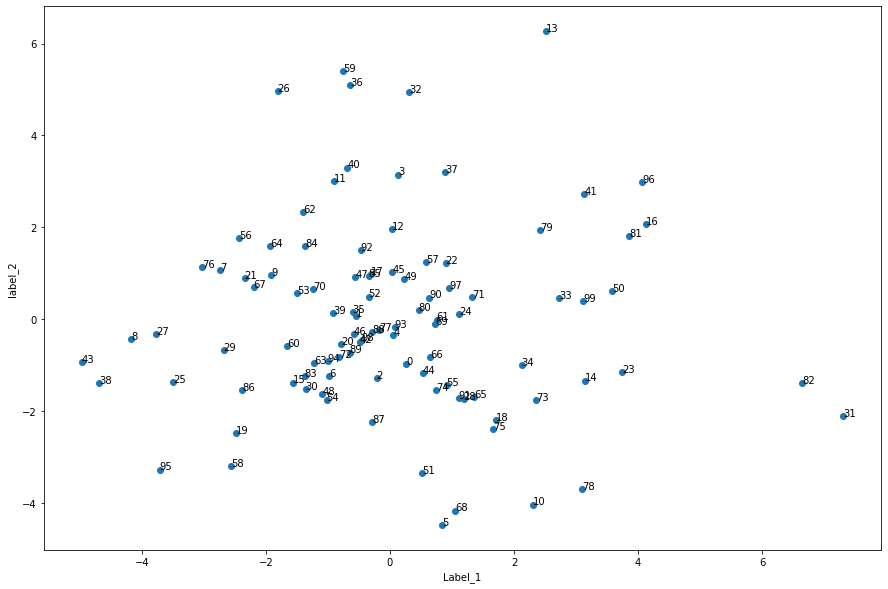

In [10]:
plot_nodes(embedding,nodes)


Cet exemple n'est pas très intéressant, puisqu'on a aucun moyen de mesurer la qualité ou l'intérêt de ce plongement. 
--> **Un plongement n'est intéressant que pour une tâche fixée a priori.**

On va donc s'intéresser à un jeu de données avec des clusters bien identifiés et voir si DeepWalk nous permet de faire de la classification non supervisée sur les données.


**Question** : On va maintenant utiliser `DeepWalk` sur un graphe de similarité construit à partir d'un tableau de données :

- Choisissez une dimension p ;
- Générez n vecteurs suivant un mélange de 2 gaussiennes en dimension p (vous pourrez choisir les paramètres des gaussiennes) ;
- Créez un graphe de similarité sur ces n données ;
- puis faites tourner l'algo DeepWalk sur ce graphe, avec la bonne dimension et une dimension différente ; observez les résultats.

In [11]:
p=6 # dimension 
n=100 # nb observations
rd.seed(11)

# 50% of points are N_p(0,1)
mean = np.zeros(p)
cov= np.identity(p)
X1=np.random.multivariate_normal(mean, cov, size=int(n/2))

# remaining 50% of points are of another Gaussian
# first choice of parameters
#m2=np.zeros(p)+4
#c2=cov

# second choice of parameters
m2= np.array([1,1,1,2,3,4])
c2= np.array([[2,0,0,0,0,0],
             [0,0.5,0,0,0,0],
             [0,0,1,2,2,2],
             [0,0,2,1.5,3,2],
             [0,0,2,3,2.5,0.5],
             [0,0,2,2,0.5,4]])
print(c2)

# help(np.random.multivariate_normal)
X2=np.random.multivariate_normal(m2, c2, size=int(n/2))
X=np.concatenate([X1,X2])
X.shape

[[2.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0. ]
 [0.  0.  1.  2.  2.  2. ]
 [0.  0.  2.  1.5 3.  2. ]
 [0.  0.  2.  3.  2.5 0.5]
 [0.  0.  2.  2.  0.5 4. ]]


/var/folders/4k/m7l1y7zn415bxwg1svgbpfs00000gn/T/ipykernel_27082/77966482.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  X2=np.random.multivariate_normal(m2, c2, size=int(n/2))


(100, 6)

Note : on aurait aussi pu utiliser la fonction `make_blobs` de `sklearn.datasets` pour créer les données sous le mélange (mais ça ne créé que des Gaussiennes isotropes).


Vérifions que les données d'origine sont bien séparées : 

In [12]:
# plot nodes graph
def plot_nodes_with_groups(embedding,node_no,labels):
    X = embedding[node_no]
      
    pca = PCA(n_components=2)
    pca_out= pca.fit_transform(X)
      
    # use colormap
    colormap = np.array(['r', 'g', 'b'])
    
    plt.figure(figsize=(15,10))
    plt.scatter(pca_out[:, 0], pca_out[:, 1],color=colormap[labels.astype(int)])
    
    for i, node in enumerate(node_no):
        plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
    plt.xlabel('Label_1')
    plt.ylabel('label_2')
    plt.show()

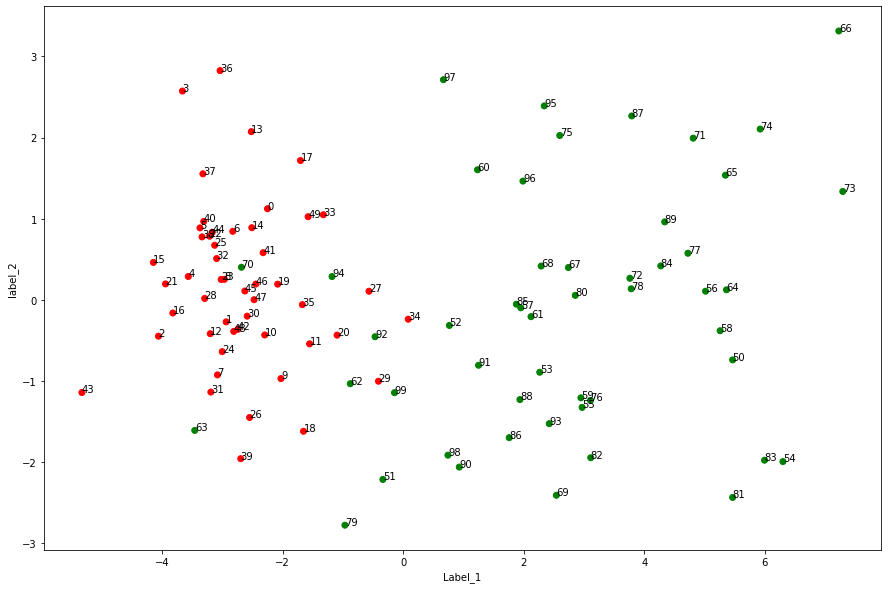

In [13]:
labels=np.concatenate((np.zeros(50),np.zeros(50)+1))
plot_nodes_with_groups(X,range(n),labels)


On va maintenant écrire une fonction de similarité, avec le noyau Gaussien :

In [14]:
# calcul de la similiarité gaussienne entre deux points dans R^p
def simi_exp(x1, x2, sigma = 1):
    return np.exp(-np.sum((x1 - x2)**2) /(2 * sigma**2))

# test de la fonction 
#simi_exp(np.array([1,2]),np.array([3,4]))

# construction de la matrice de similarité gaussienne d'un jeu de données
def similarity(df):
    n =len(df)
    S=np.zeros(shape=[n,n])
    for i in range(n-1):
        for j in range(i+1, n):
            S[i,j] = simi_exp(df[i, ], df[j, ])
            
    S = S+S.transpose()
    return S
        
# test de la fonction
# similarity(X).shape

On transforme les données en graphe (valué) dont on va faire l'embedding

In [15]:
G_adj = similarity(X)
#help(nx.from_numpy_matrix)
G=nx.from_numpy_matrix(G_adj)
#print(len(G))

# train model and generate embedding
model = DeepWalk(walk_number=20,walk_length=100, dimensions=p, window_size=5)
model.fit(G)
embedding = model.get_embedding()

# print Embedding shape
print(embedding.shape)


(100, 6)


On visualise le résultat, avec les classes d'origine :

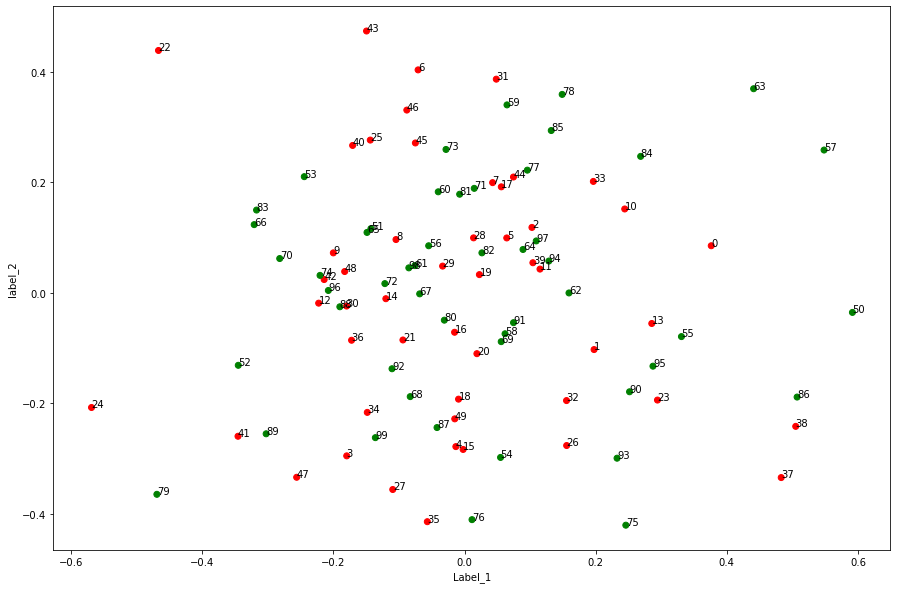

In [16]:
plot_nodes_with_groups(embedding,range(n),labels)

Le plongement ne nous a pas permis de séparer les noeuds.

Pourquoi ? 

C'est très simple : DeepWalk ne prend pas en compte les valeurs d'un graphe valué (il ne considère que sa version binarisée). Or, on lui a donné un graphe de similarité exponentielle sans faire de seuillage : donc le graphe est **complet**. Il ne contient aucune information de communauté. À partir d'un noeud, tous les autres noeuds du graphe ont la même proba uniforme d'être visité. 


Il fallait donc faire un graphe avec un seuil de similarité. On recommence. 




In [17]:
seuil=np.quantile(G_adj,0.75) # on garde 25% des arêtes 
G_adj_sparse =(G_adj >seuil) * G_adj
#G_adj_sparse 

G_sparse=nx.from_numpy_matrix(G_adj_sparse)
nx.density(G_sparse)


0.25252525252525254

(100, 6)


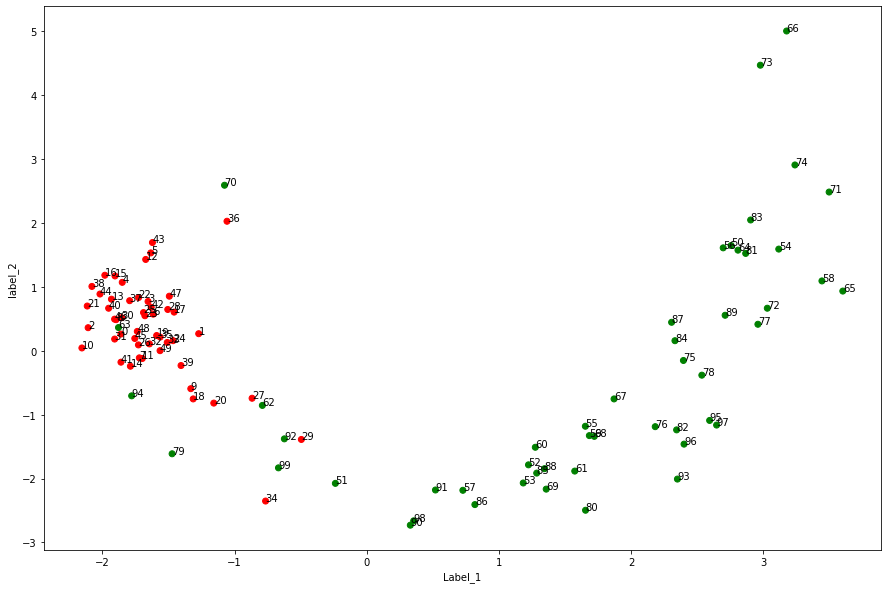

In [18]:
# train model and generate embedding
model = DeepWalk(walk_number=20,walk_length=100, dimensions=p, window_size=5)
model.fit(G_sparse)
embedding_sparse = model.get_embedding()

# print Embedding shape
print(embedding_sparse.shape)

plot_nodes_with_groups(embedding_sparse,range(n),labels)

Cette fois ça fonctionne : on sépare correctement les points. 

Vous pouvez faire varier les différents paramètres (construction du graphe de similarité et paramètres de DeepWalk) pour voir comment ces résultats évoluent. 

## Node2vec

On rappelle que Node2vec est une version améliorée de DeepWalk, dans laquelle la marche aléatoire est biaisée. 
La page officielle de Node2Vec est ici https://github.com/eliorc/node2vec 
On va suivre l'exemple en démo. 

Commencez par installer node2vec dans un terminal avec `pip install node2vec` ou depuis le notebook (mais ce n'est pas recommandé) et importez la librairie. 


In [19]:
#import sys
#!{sys.executable} -m  pip install node2vec

from node2vec import Node2Vec

On va ensuite tester la méthode sur le graphe de similarité G obtenu ci-dessus. 

Les options de Node2Vec sont similaires à celles de DeepWalk 
- `dimensions`: Embedding dimensions (default: 128)
- `walk_length`: Number of nodes in each walk (default: 80)
- `num_walks`: Number of walks per node (default: 10)
- `p`: Return hyper parameter (default: 1)
- `q`: Inout parameter (default: 1)

Si vous laissez les valeurs de `p,q` par défaut (= à 1), vous retombez sur la méthode DeepWalk quand vous traitez un graphe binaire, donc ça n'a pas d'intérêt. 

Par contre, **dans le cas valué, Node2Vec va prendre en compte les valeurs des arêtes** donc même avec $p=q=1$, on ne devrait pas avoir le même résultat que DeepWalk.  

C'est ce qu'on va vérifier avec le graphe de similarité complet ci-dessus. 

Notez que contrairement à `DeepWalk` :
 - les données se passent dans le modèle (parce que les probas de la marche aléatoire dépendent des voisinages ; quand on réfléchit à ça, on comprend pourquoi dans l'implémentation de Node2Vec, c'est pas plus compliqué de rajouter les poids des arêtes, ce qui a donc été fait. d'un point de vue architecture logicielle, c'est quand même nettement plus compliqué que DeepWalk).
  - la taille de la fenêtre `window` n'est pas un paramètre du modèle mais de la fonction d'ajustement aux données `fit` 


In [20]:
#help(Node2Vec)
#help(Node2Vec.fit)

# The Node2Vec.fit method accepts any keyword argument acceptable by gensim.Word2Vec
# On importe Word2Vec pour accéder à l'aide 
from gensim.models import Word2Vec 
#help(Word2Vec)


In [21]:
# Precompute probabilities and generate walks 
n2v_model = Node2Vec(G, dimensions=p, walk_length=100, num_walks=20,p=1,q=1)  # Use temp_folder for big graphs

# Embed nodes
model = n2v_model.fit(window=5, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Save embeddings for later use
#model.wv.save_word2vec_format('mon_plongement')

# Save model for later use
#model.save('mon_modele')

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 20/20 [00:03<00:00,  6.42it/s]


In [22]:
# Look for topn most similar nodes to node with index '99'
model.wv.most_similar(positive='99',topn = 13)  # Output node names are always strings
                                                # second value is similarity


[('29', 0.996159017086029),
 ('51', 0.9695693850517273),
 ('98', 0.9687507748603821),
 ('92', 0.9378339052200317),
 ('91', 0.9344240427017212),
 ('85', 0.8511831164360046),
 ('68', 0.8352721333503723),
 ('61', 0.820167064666748),
 ('35', 0.7750018239021301),
 ('27', 0.7550662755966187),
 ('53', 0.7480963468551636),
 ('52', 0.7353335022926331),
 ('88', 0.7334021329879761)]

In [23]:
# Look for topn less similar nodes to node with index '12'
model.wv.most_similar(negative='12',topn=12)  # Output node names are always strings
                                             # second value is similarity
                                            # can be negative - those of you who know SkipGram may understand why

[('59', 0.08873756229877472),
 ('76', 0.08489739149808884),
 ('55', 0.07557833194732666),
 ('84', 0.07212916761636734),
 ('80', 0.053830359131097794),
 ('89', 0.052393946796655655),
 ('82', 0.050877343863248825),
 ('57', 0.031312745064496994),
 ('81', 0.020898597314953804),
 ('56', 0.020041435956954956),
 ('77', 0.018102120608091354),
 ('86', 0.012875266373157501)]

Déjà on constate que les noeuds les plus (resp. les moins) similaires à un noeud donné semblent être dans le même (resp. l'autre) cluster.

**Question** : visualisez le plongement obtenu et commentez les résultats vis-à-vis des 2 clusters initiaux.

[]

<Figure size 432x288 with 0 Axes>

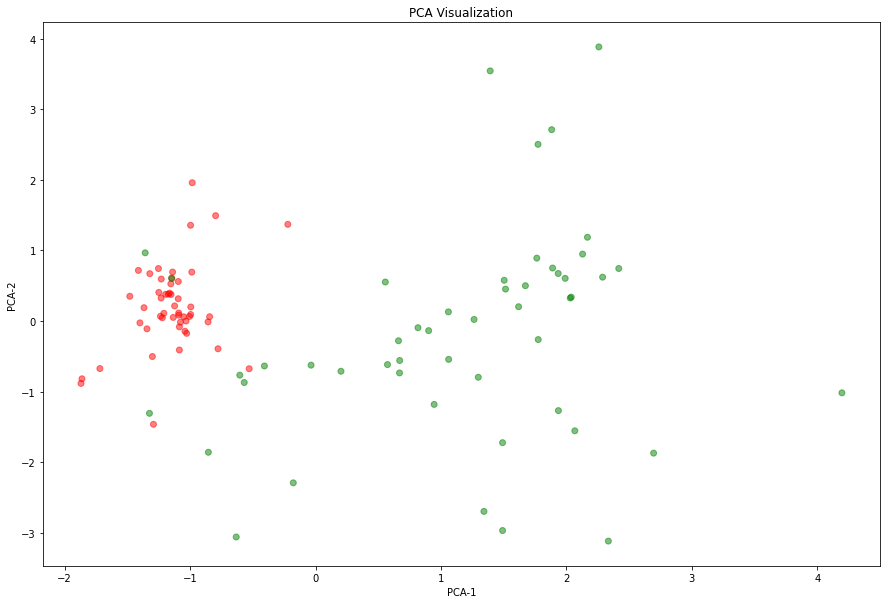

In [24]:
# Convert to dataframe 
emb_df = (
    pd.DataFrame(
        [model.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

pca = PCA(n_components=2)
pca_out= pca.fit_transform(emb_df)
      

# use colormap
colormap = np.array(['r', 'g', 'b'])

############
######    
    
d = {'x': pca_out[:, 0], 'y': pca_out[:, 1], 'labs': labels}    
emb_df_PCA = (
    pd.DataFrame(
        d,
        index = emb_df.index
    )
)

# Visualize embedding    
plt.clf()
fig = plt.figure(figsize=(15,10))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    #s = 0.4,
    color = colormap[labels.astype(int)],
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()    

Pour le coup on a assez bien séparé les points en utilisant la 'vraie' dimension de départ des données. Il faudrait explorer ce qui se passe si on a moins de dimensions (ou plus ?) et si on modifie les paramètres de Node2Vec.

Vous pouvez également voir ce qui se passe pour le graphe $G_{sparse}$ et en choisissant différents paramètres de $p,q$.
Note : on ne sait pas forcément comment choisir les paramètres $p$ et $q$. 
(In node2vec paper they searched the [0.25,4]*[0.25,4] grid and it did have a significant impact on performance, for the task of multi-label node classification.)
